# This is the same thing as MultinomialLogReg.ipynb but instead of using malaria as a reference group each group is compared to every other group so {p0,...,p5} represent the probability of being in each group compared to every other and the max(p0,...,p5) determines the final diagnosis.

In [353]:
%reset -f
%matplotlib inline

import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
dirToInclude=parentdir +'/features/'
sys.path.insert(0,dirToInclude)


import pandas
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

import scipy as sp
import theano.tensor as t

In [354]:
#Read in Stata datafile
#data_stata = pd.io.stata.read_stata('../ProjectDef/cnsfinall2.dta')
#Convert to .csv. Now you never need to do this again
#data_stata.to_csv('../Data/cns_data.csv')

In [355]:
data = pd.read_csv("../Data/cns_data.csv")
rf_results = pd.read_csv("Outputs/rf_results.csv")

In [356]:
#Adding a variable that is just 'month and day' - seems better to capture seasonality.
data['month'] = pd.DatetimeIndex(data['incdate']).month
data['day'] = pd.DatetimeIndex(data['incdate']).day
data['monthday'] = data['month']*30+data['day']

In [357]:
var = data.loc[:,['glasgtot','blanttot','clinjaund','clinhepato','clinspleno','clinconv','clindehyd',\
                          'clinoedem','clinlymph','clinresp','clinablung','clincyan','clincapref','clincoldext',\
                         'clinearinf','clinanemia','clintonsil','clinorcand','clinhemmor','clinaids',\
                         'abdpain','vom','diar','head','muscle','conv',\
                         'sex','ageyrs','agemth','incdate',\
                         'temp','card','resp','sbp','dbp','weight','height','muac',\
                          'mhhosp', 'mhdevsp', 'mhsickle', 'mhchronstat',\
                         'monthday','dimain', \
                         'incirrit', 'inchead', 'incphoto',\
                         'incfont', 'incneuro' , 'incseiza', 'incseizh',\
                          'incpurp','diag']] #This is the final diagnosis - will be the 'label'


In [358]:
#Convert the date into a useful value. This just counts the days from the beginning of the dataset 
var['incdate'] = pd.to_datetime(var['incdate'])
var['date'] = (var['incdate'] - var['incdate'].min())  / np.timedelta64(1,'D')

#Mapping yes/no to 1/0
var['clinjaund'] = var.clinjaund.map({'Yes': 1, 'No': 0})
var['clinhepato'] = var.clinhepato.map({'Yes': 1, 'No': 0})
var['clinspleno'] = var.clinspleno.map({'Yes': 1, 'No': 0})
var['clinconv'] = var.clinconv.map({'Yes': 1, 'No': 0})
var['clindehyd'] = var.clindehyd.map({'Yes': 1, 'No': 0})
var['clinoedem'] = var.clinoedem.map({'Yes': 1, 'No': 0})
var['clinlymph'] = var.clinlymph.map({'Yes': 1, 'No': 0})
var['clinresp'] = var.clinresp.map({'Yes': 1, 'No': 0})
var['clinablung'] = var.clinablung.map({'Yes': 1, 'No': 0})
var['clincyan'] = var.clincyan.map({'Yes': 1, 'No': 0})
var['clincapref'] = var.clincapref.map({'Yes': 1, 'No': 0})
var['clincoldext'] = var.clincoldext.map({'Yes': 1, 'No': 0})
var['clinearinf'] = var.clinearinf.map({'Yes': 1, 'No': 0})
var['clintonsil'] = var.clintonsil.map({'Yes': 1, 'No': 0})
var['clinorcand'] = var.clinorcand.map({'Yes': 1, 'No': 0})
var['clinhemmor'] = var.clinhemmor.map({'Yes': 1, 'No': 0})
var['clinaids'] = var.clinaids.map({'Yes': 1, 'No': 0})
var['vom'] = var.vom.map({'Yes': 1, 'No': 0})
var['diar'] = var.diar.map({'Yes': 1, 'No': 0})
var['headache'] = var['head'] #Since 'head' is a function
var['conv'] = var.conv.map({'Yes': 1, 'No': 0})
var['ageym'] = var.ageyrs.astype(float)*12.
var.agemth = var.agemth.astype(float)
var['age'] = var.ageym + var.agemth


#Medical history variables
var['mhhosp'] = var.mhhosp.map({'Yes': 1, 'No':0})


#some slightly more compliated mappings
var['abdpain'] = var.abdpain.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})
var['headache'] = var.headache.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
var['muscle'] = var.muscle.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})

var['dimain'] = var.dimain.map({"Cerebral Malaria":0, "Meningoencephalitis":1, "Meningitis":2.,\
                                       "Other":3})

var['mhdevsp'] = var.mhdevsp.map({'OTHER':1, 'GLOBAL DEVELOPMENTAL DELAY':1, 'HYDROCEPHALUS':1,
       'HEARING LOSSES':1, 'MOTOR DEVELOPEMENTAL DELAY':1,
       'SPEECH DEVELOPEMENTAL DELAY':1})

#Mapping of inclusion variables 6-8 MLW
var['incirrit'] = var.incirrit.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
var['inchead'] = var.inchead.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
var['incphoto'] = var.incphoto.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
var['incfont'] = var.incfont.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
var['incneuro'] = var.incneuro.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
var['incseiza'] = var.incseiza.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
var['incseizh'] = var.incseizh.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
var['incpurp'] = var.incpurp.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})


#To begin simply, I'll just separate malaria from bacterial to avoid multinomial
var['diag'] = var.diag.map({'malaria':0, 'cereb malaria':0,'virus-malaria':0,\
                                    'virus-bacteria':1, 'bacteremia':1,'bact meningitis':1,\
                                    'virus-other':2,'virus':2,'malaria-bacterial':3,\
                                    'tb':4,'crypto':4, '0.0':5})

In [359]:
#A lot of these have very few actual answers. i.e., 'headache.' What happens if you map 'nan' to 'No'?
#This is probably something we'll want to play around with.
values = {'clinjaund':0,'clinhepato':0,'clinaids':0,'clinhemmor':0,'clinorcand':0,'clintonsil':0,'clinearinf':0,\
          'clinresp':0,'clinlymph':0,'clindehyd':0,'clinoedem':0,'clinablung':0,'clincyan':0,'clincapref':0,
          'clincoldext':0, 'mhchronstat':0, 'mhdevsp':0,\
         'conv':0,'abdpain':0,'vom':0,'diar':0,'headache':0,'muscle':0}
var = var.fillna(value=values)

In [360]:
#You really shouldn't use the initial diagnosis as a continuous variable ,
#you need to map it into a set of yes/no question.
var['CMalaria'] = var.dimain.map({0:1,1:0,2:0,3:0})
var['Enceph'] = var.dimain.map({0:0,1:1,2:0,3:0})
var['Mening'] = var.dimain.map({0:0,1:0,2:1,3:0})
var['Other'] = var.dimain.map({0:0,1:0,2:0,3:1})


In [361]:
#NB, overwriting var with data exported from another notebook, delete unessecary code above
var = rf_results
#Keep only what we are using
var = var.loc[:,['CMalaria','Mening','Enceph','glasgtot','sbp','diag','patientid']]
#var = var.loc[:,['CMalaria','Mening','Enceph','glasgtot','sbp','diag']]

In [362]:
#Drop NaNs
var = var.dropna()

In [363]:
var.shape

(361, 7)

In [364]:
#Separate into train and test (same split as in random forest analysis)
test = var[0:120]
train = var[120:361]
test.shape

(120, 7)

# Adapted from https://nbviewer.jupyter.org/gist/ceshine/c9a4308384e744f062f5

In [365]:
y = train['diag'].copy()
#y = y[np.isin(y,[0,1])] #logreg comparison of mal and bact groups
y[y==1] = 10 # Set mal to 1 other to 0
y[y==2] = 10
y[y==3] = 10
y[y==4] = 10
y[y==5] = 10
y[y==0] = 1
y[y==10] = 0

In [366]:
x = train[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [367]:
patientid = train['patientid']
patientid = patientid[y.index]

In [368]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [369]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [370]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:15<00:00, 194.70it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1192192b0>,
      dtype=object)

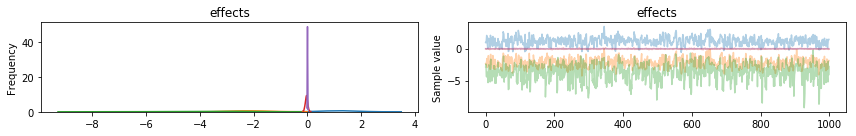

In [371]:
pm.traceplot(trace)

In [372]:
new_y = test['diag']


In [373]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [374]:
new_patientid = test['patientid']


In [375]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [376]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of bacterial by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
eta[:20]

array([ 0.84359607,  0.91774754,  0.95519938,  0.95457253,  0.88405682,
        0.91950273, -4.19154121, -2.71177235,  1.06454602, -2.71039327,
       -2.71189772, -4.26318526,  0.95432179, -2.71152161,  0.92852944,
       -4.30189082, -4.30189082, -2.71102012, -2.52952796, -4.29587301])

In [377]:
p = invlogit(eta) #probability of malaria infection

p[:20]

array([0.69922205, 0.71458293, 0.72215961, 0.72203382, 0.70766219,
       0.71494077, 0.01489766, 0.06228226, 0.74355834, 0.06236285,
       0.06227494, 0.01388197, 0.72198349, 0.06229691, 0.71677685,
       0.01336197, 0.01336197, 0.06232621, 0.07381391, 0.01344154])

In [378]:
prediction = pd.DataFrame({'p_mal':p}) #build df to visualize results
prediction['pred_mal'] = (prediction['p_mal'] > .5) * 1

In [379]:
prediction["diag"] = new_y.reset_index(drop=True)
prediction["CMalaria"] = new_x.reset_index(drop=True)["CMalaria"]
prediction["Enceph"] = new_x.reset_index(drop=True)["Enceph"]
prediction["Mening"] = new_x.reset_index(drop=True)["Mening"]
prediction["glasgtot"] = new_x.reset_index(drop=True)["glasgtot"]
prediction["sbp"] = new_x.reset_index(drop=True)["sbp"]
prediction["patientid"] = new_patientid.reset_index(drop=True)
prediction.head(5) #observe pred_diag compared to diag to see difference between prediction and actual diagnosis

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid
0,0.699222,1,0.0,1.0,0.0,0.0,9.0,86.0,244.0
1,0.714583,1,0.0,1.0,0.0,0.0,7.0,94.0,100.0
2,0.722160,1,5.0,1.0,0.0,0.0,6.0,101.0,66.0
3,0.722034,1,0.0,1.0,0.0,0.0,6.0,96.0,432.0
4,0.707662,1,0.0,1.0,0.0,0.0,8.0,117.0,127.0


In [380]:
#Now do bact

In [410]:
y = train['diag'].copy()
y[y==2] = 0
y[y==3] = 0
y[y==4] = 0
y[y==5] = 0

In [384]:
x = train[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [385]:
patientid = train['patientid']
patientid = patientid[y.index]

In [386]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [391]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [392]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:14<00:00, 211.48it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [393]:
new_y = test['diag']

In [394]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [395]:
new_patientid = test['patientid']

In [396]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [397]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of viral by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
eta[:20]

array([-3.38827631, -3.5597377 , -3.69638938, -3.61152108, -3.93229585,
       -3.79736896, -2.74834923, -0.54669465, -3.69897655, -0.73340492,
       -0.52972099, -2.91636106, -3.57757375, -0.58064197, -5.01947255,
       -2.60997277, -2.60997277, -0.64853661, -0.5510066 , -3.4247085 ])

In [398]:
p = invlogit(eta) #probability of viral infection

p[:20]

array([0.03266387, 0.02765948, 0.02421218, 0.02630034, 0.0192219 ,
       0.02193765, 0.06017995, 0.36663162, 0.02415113, 0.32444799,
       0.37058197, 0.05135068, 0.02718381, 0.35878489, 0.00656463,
       0.06849934, 0.06849934, 0.34331938, 0.3656309 , 0.03153212])

In [401]:
prediction['p_bact'] = p
prediction['pred_bact'] = (prediction['p_bact'] > .5) * 1
prediction.head(5)

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid,p_bact,pred_bact
0,0.699222,1,0.0,1.0,0.0,0.0,9.0,86.0,244.0,0.032664,0
1,0.714583,1,0.0,1.0,0.0,0.0,7.0,94.0,100.0,0.027659,0
2,0.722160,1,5.0,1.0,0.0,0.0,6.0,101.0,66.0,0.024212,0
3,0.722034,1,0.0,1.0,0.0,0.0,6.0,96.0,432.0,0.026300,0
4,0.707662,1,0.0,1.0,0.0,0.0,8.0,117.0,127.0,0.019222,0


In [407]:
# Now do vir

In [411]:
y = train['diag'].copy()
y[y==1] = 0
y[y==3] = 0
y[y==4] = 0
y[y==5] = 0
y[y==2] = 1

In [412]:
x = train[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [413]:
patientid = train['patientid']
patientid = patientid[y.index]

In [414]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [431]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [432]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:17<00:00, 176.30it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [433]:
new_y = test['diag']

In [434]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [435]:
new_patientid = test['patientid']

In [436]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [438]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of viral by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
eta[:20]

array([ -5.03785247,  -5.08796816,  -5.22736729,  -5.03679849,
        -6.09198181,  -5.62156079, -12.86844821,  -5.92088468,
        -4.73083444,  -6.34013603,  -5.88277093, -13.5806077 ,
        -4.96057097,  -5.9971122 ,  -8.36575144, -13.06007099,
       -13.06007099,  -6.14956724,  -5.09332994, -14.88953142])

In [439]:
p = invlogit(eta) #probability of viral infection

p[:20]

array([6.44584731e-03, 6.13270258e-03, 5.33898046e-03, 6.45260083e-03,
       2.25582350e-03, 3.60593837e-03, 2.57811824e-06, 2.67564738e-03,
       8.74201222e-03, 1.76095581e-03, 2.77930578e-03, 1.26478430e-06,
       6.96014168e-03, 2.47975618e-03, 2.32647968e-04, 2.12854244e-06,
       2.12854244e-06, 2.12985928e-03, 6.10010846e-03, 3.41631980e-07])

In [440]:
prediction['p_vir'] = p
prediction['pred_vir'] = (prediction['p_vir'] > .5) * 1
prediction.head(5)

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid,p_bact,pred_bact,p_vir,pred_vir
0,0.699222,1,0.0,1.0,0.0,0.0,9.0,86.0,244.0,0.032664,0,0.006446,0
1,0.714583,1,0.0,1.0,0.0,0.0,7.0,94.0,100.0,0.027659,0,0.006133,0
2,0.722160,1,5.0,1.0,0.0,0.0,6.0,101.0,66.0,0.024212,0,0.005339,0
3,0.722034,1,0.0,1.0,0.0,0.0,6.0,96.0,432.0,0.026300,0,0.006453,0
4,0.707662,1,0.0,1.0,0.0,0.0,8.0,117.0,127.0,0.019222,0,0.002256,0


In [441]:
#do mal&bact

In [442]:
y = train['diag'].copy()
y[y==1] = 0
y[y==2] = 0
y[y==4] = 0
y[y==5] = 0
y[y==3] = 1

In [443]:
x = train[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [444]:
patientid = train['patientid']
patientid = patientid[y.index]

In [445]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [446]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [447]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:13<00:00, 217.23it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [448]:
new_y = test['diag']

In [449]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [450]:
new_patientid = test['patientid']

In [451]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [452]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of viral by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
eta[:20]

array([ -3.5916993 ,  -3.42528297,  -3.37920784,  -3.31731943,
        -3.84268855,  -3.59857051, -11.67612284, -12.62260936,
        -2.94391811, -12.75876386, -12.61023168, -12.09009282,
        -3.29256407, -12.64736472,  -4.48976362, -12.01239112,
       -12.01239112, -12.69687545, -11.89712647, -12.60651985])

In [453]:
p = invlogit(eta) #probability of viral infection

p[:20]

array([2.68127418e-02, 3.15145851e-02, 3.29516282e-02, 3.49817865e-02,
       2.09860379e-02, 2.66340274e-02, 8.49416303e-06, 3.29662066e-06,
       5.00247471e-02, 2.87698772e-06, 3.33767862e-06, 5.61483458e-06,
       3.58271682e-02, 3.21601372e-06, 1.10987321e-02, 6.06851162e-06,
       6.06851162e-06, 3.06066448e-06, 6.80989892e-06, 3.35009048e-06])

In [454]:
prediction['p_mal&bact'] = p
prediction['pred_mal&bact'] = (prediction['p_mal&bact'] > .5) * 1
prediction.head(5)

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid,p_bact,pred_bact,p_vir,pred_vir,p_mal&bact,pred_mal&bact
0,0.699222,1,0.0,1.0,0.0,0.0,9.0,86.0,244.0,0.032664,0,0.006446,0,0.026813,0
1,0.714583,1,0.0,1.0,0.0,0.0,7.0,94.0,100.0,0.027659,0,0.006133,0,0.031515,0
2,0.722160,1,5.0,1.0,0.0,0.0,6.0,101.0,66.0,0.024212,0,0.005339,0,0.032952,0
3,0.722034,1,0.0,1.0,0.0,0.0,6.0,96.0,432.0,0.026300,0,0.006453,0,0.034982,0
4,0.707662,1,0.0,1.0,0.0,0.0,8.0,117.0,127.0,0.019222,0,0.002256,0,0.020986,0


In [455]:
#now do tbcrypto

In [456]:
y = train['diag'].copy()
y[y==1] = 0
y[y==2] = 0
y[y==3] = 0
y[y==5] = 0
y[y==4] = 1

In [457]:
x = train[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [458]:
patientid = train['patientid']
patientid = patientid[y.index]

In [459]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [474]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [475]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:14<00:00, 211.11it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [476]:
new_y = test['diag']

In [477]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [478]:
new_patientid = test['patientid']

In [479]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [480]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of viral by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
eta[:20]

array([-12.56612504, -12.12202246, -11.90643278, -11.89566342,
       -12.40222833, -12.15217668, -11.63753338,  -4.13409823,
       -11.2079708 ,  -4.15779083,  -4.13194435, -12.12471344,
       -11.89135567,  -4.13840597, -12.30725557, -12.31876437,
       -12.31876437,  -4.14702147,  -2.96999493, -12.4221503 ])

In [481]:
p = invlogit(eta) #probability of viral infection

p[:20]

array([3.48818669e-06, 5.43838783e-06, 6.74681828e-06, 6.81986939e-06,
       4.10940446e-06, 5.27684614e-06, 8.82835188e-06, 1.57645992e-02,
       1.35654509e-05, 1.54011695e-02, 1.57980537e-02, 5.42377300e-06,
       6.84931083e-06, 1.56978991e-02, 4.51881808e-06, 4.46711022e-06,
       4.46711022e-06, 1.55653310e-02, 4.87999584e-02, 4.02834746e-06])

In [482]:
prediction['p_tbcrypto'] = p
prediction['pred_tbcrypto'] = (prediction['p_tbcrypto'] > .5) * 1
prediction.head(5)

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid,p_bact,pred_bact,p_vir,pred_vir,p_mal&bact,pred_mal&bact,p_tbcrypto,pred_tbcrypto
0,0.699222,1,0.0,1.0,0.0,0.0,9.0,86.0,244.0,0.032664,0,0.006446,0,0.026813,0,0.000003,0
1,0.714583,1,0.0,1.0,0.0,0.0,7.0,94.0,100.0,0.027659,0,0.006133,0,0.031515,0,0.000005,0
2,0.722160,1,5.0,1.0,0.0,0.0,6.0,101.0,66.0,0.024212,0,0.005339,0,0.032952,0,0.000007,0
3,0.722034,1,0.0,1.0,0.0,0.0,6.0,96.0,432.0,0.026300,0,0.006453,0,0.034982,0,0.000007,0
4,0.707662,1,0.0,1.0,0.0,0.0,8.0,117.0,127.0,0.019222,0,0.002256,0,0.020986,0,0.000004,0


In [483]:
#Now do Other

In [486]:
y = train['diag'].copy()
y[y==1] = 0
y[y==2] = 0
y[y==3] = 0
y[y==4] = 0
y[y==5] = 1

In [487]:
x = train[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [488]:
patientid = train['patientid']
patientid = patientid[y.index]

In [489]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [490]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [491]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:14<00:00, 204.03it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [492]:
new_y = test['diag']

In [493]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [494]:
new_patientid = test['patientid']

In [495]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [496]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of viral by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
eta[:20]

array([-1.18819022, -1.19858134, -1.21625156, -1.19546045, -1.30565778,
       -1.25679645,  2.35660883,  0.12596808, -1.16946491,  0.08022764,
        0.1301263 ,  2.28383551, -1.18714401,  0.11765164, -1.55618844,
        2.34308795,  2.34308795,  0.10101875,  0.20394584,  2.1434933 ])

In [497]:
p = invlogit(eta)

p[:20]

array([0.23358277, 0.23172768, 0.22859678, 0.23228376, 0.21321436,
       0.22152586, 0.9134581 , 0.53145044, 0.23695172, 0.52004616,
       0.53248575, 0.90752943, 0.23377012, 0.52937903, 0.17419426,
       0.91238325, 0.91238325, 0.52523323, 0.55081046, 0.89505918])

In [504]:
prediction['p_other'] = p
prediction['pred_other'] = (prediction['p_other'] > .5) * 1
prediction.head(5)

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid,p_bact,pred_bact,p_vir,pred_vir,p_mal&bact,pred_mal&bact,p_tbcrypto,pred_tbcrypto,p_other,pred_other
0,0.699222,1,0.0,1.0,0.0,0.0,9.0,86.0,244.0,0.032664,0,0.006446,0,0.026813,0,0.000003,0,0.233583,0
1,0.714583,1,0.0,1.0,0.0,0.0,7.0,94.0,100.0,0.027659,0,0.006133,0,0.031515,0,0.000005,0,0.231728,0
2,0.722160,1,5.0,1.0,0.0,0.0,6.0,101.0,66.0,0.024212,0,0.005339,0,0.032952,0,0.000007,0,0.228597,0
3,0.722034,1,0.0,1.0,0.0,0.0,6.0,96.0,432.0,0.026300,0,0.006453,0,0.034982,0,0.000007,0,0.232284,0
4,0.707662,1,0.0,1.0,0.0,0.0,8.0,117.0,127.0,0.019222,0,0.002256,0,0.020986,0,0.000004,0,0.213214,0


# Begin second Group

In [521]:
test = var[120:240]
train = var.drop(var.index[120:240])
test.shape

(120, 7)

In [522]:
y = train['diag'].copy()
#y = y[np.isin(y,[0,1])] #logreg comparison of mal and bact groups
y[y==1] = 10 # Set mal to 1 other to 0
y[y==2] = 10
y[y==3] = 10
y[y==4] = 10
y[y==5] = 10
y[y==0] = 1
y[y==10] = 0

In [523]:
x = train[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [524]:
patientid = train['patientid']
patientid = patientid[y.index]

In [525]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [526]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [527]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:14<00:00, 203.47it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119aaa240>,
      dtype=object)

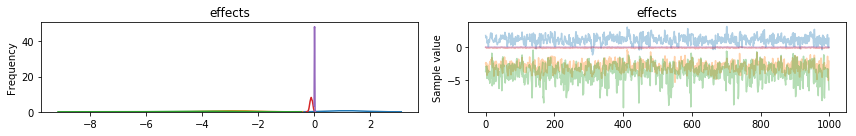

In [528]:
pm.traceplot(trace)

In [529]:
new_y = test['diag']


In [530]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [531]:
new_patientid = test['patientid']


In [532]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [533]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of bacterial by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
eta[:20]

array([-3.49174435, -3.32475333, -3.90091929, -4.61501282, -4.30419583,
       -4.12955001, -3.74857643,  1.63706145,  1.32362597,  1.59214092,
       -3.649671  ,  1.12843359, -3.37873824, -3.45065122,  1.07062129,
       -0.37910324, -0.74390513,  1.68460047,  1.05652061, -3.1063959 ])

In [534]:
p = invlogit(eta) #probability of malaria infection

p[:20]

array([0.02954804, 0.0347317 , 0.01982244, 0.00980497, 0.01333161,
       0.01583533, 0.02300935, 0.83713469, 0.78978434, 0.8309171 ,
       0.02534083, 0.75554971, 0.0329666 , 0.03074944, 0.74471505,
       0.4063432 , 0.32215079, 0.84351275, 0.74202507, 0.0428442 ])

In [535]:
prediction2 = pd.DataFrame({'p_mal':p}) #build df to visualize results
prediction2['pred_mal'] = (prediction2['p_mal'] > .5) * 1

In [538]:
prediction2["diag"] = new_y.reset_index(drop=True)
prediction2["CMalaria"] = new_x.reset_index(drop=True)["CMalaria"]
prediction2["Enceph"] = new_x.reset_index(drop=True)["Enceph"]
prediction2["Mening"] = new_x.reset_index(drop=True)["Mening"]
prediction2["glasgtot"] = new_x.reset_index(drop=True)["glasgtot"]
prediction2["sbp"] = new_x.reset_index(drop=True)["sbp"]
prediction2["patientid"] = new_patientid.reset_index(drop=True)
prediction2.head(5) #observe pred_diag compared to diag to see difference between prediction and actual diagnosis

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid
0,0.029548,0,5.0,0.0,0.0,1.0,15.0,103.0,378.0
1,0.034732,0,5.0,0.0,0.0,1.0,13.0,98.0,190.0
2,0.019822,0,5.0,0.0,1.0,0.0,11.0,118.0,98.0
3,0.009805,0,5.0,0.0,1.0,0.0,15.0,91.0,104.0
4,0.013332,0,5.0,0.0,1.0,0.0,13.0,100.0,235.0


In [380]:
#Now do bact

In [539]:
y = train['diag'].copy()
y[y==2] = 0
y[y==3] = 0
y[y==4] = 0
y[y==5] = 0

In [540]:
x = train[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [541]:
patientid = train['patientid']
patientid = patientid[y.index]

In [542]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [543]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [544]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:14<00:00, 211.42it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [545]:
new_y = test['diag']

In [546]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [547]:
new_patientid = test['patientid']

In [548]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [549]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of viral by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
eta[:20]

array([-0.66099558, -0.53938367, -2.42932193, -2.33497354, -2.34109166,
       -2.4961924 , -0.43290625, -4.19162595, -4.45309691, -4.01677533,
       -0.38578566, -4.27974902, -0.76135489, -0.69748988, -4.36336391,
       -1.1478531 , -1.3637062 , -4.09888749, -4.21588401, -0.46338963])

In [550]:
p = invlogit(eta) #probability of viral infection

p[:20]

array([0.340516  , 0.36833097, 0.08096391, 0.08826759, 0.08777646,
       0.07612554, 0.39343256, 0.01489642, 0.01150847, 0.0176923 ,
       0.40473223, 0.01365704, 0.31835218, 0.33236899, 0.01257532,
       0.24088144, 0.20363861, 0.01632035, 0.0145446 , 0.38618202])

In [551]:
prediction2['p_bact'] = p
prediction2['pred_bact'] = (prediction2['p_bact'] > .5) * 1
prediction2.head(5)

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid,p_bact,pred_bact
0,0.029548,0,5.0,0.0,0.0,1.0,15.0,103.0,378.0,0.340516,0
1,0.034732,0,5.0,0.0,0.0,1.0,13.0,98.0,190.0,0.368331,0
2,0.019822,0,5.0,0.0,1.0,0.0,11.0,118.0,98.0,0.080964,0
3,0.009805,0,5.0,0.0,1.0,0.0,15.0,91.0,104.0,0.088268,0
4,0.013332,0,5.0,0.0,1.0,0.0,13.0,100.0,235.0,0.087776,0


In [552]:
# Now do vir

In [553]:
y = train['diag'].copy()
y[y==1] = 0
y[y==3] = 0
y[y==4] = 0
y[y==5] = 0
y[y==2] = 1

In [554]:
x = train[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [555]:
patientid = train['patientid']
patientid = patientid[y.index]

In [556]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [559]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [560]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:15<00:00, 187.85it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [561]:
new_y = test['diag']

In [562]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [563]:
new_patientid = test['patientid']

In [564]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [565]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of viral by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
eta[:20]

array([-4.00441473, -3.75885422, -4.4440474 , -4.3325015 , -4.31497712,
       -4.59187814, -3.59720735, -5.13366651, -5.65736413, -4.80728256,
       -3.49885954, -5.34788652, -4.18358598, -4.06956791, -5.51138751,
       -2.20571832, -2.64797446, -4.95387722, -5.23386845, -3.59473518])

In [566]:
p = invlogit(eta) #probability of viral infection

p[:20]

array([0.0179084 , 0.02277944, 0.01161187, 0.01296437, 0.01319054,
       0.01003214, 0.02666939, 0.00586036, 0.00347956, 0.00810382,
       0.0293447 , 0.00473566, 0.01501486, 0.01679778, 0.00402424,
       0.09923816, 0.06611396, 0.00700656, 0.00530457, 0.02673364])

In [568]:
prediction2['p_vir'] = p
prediction2['pred_vir'] = (prediction2['p_vir'] > .5) * 1
prediction2.head(5)

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid,p_bact,pred_bact,p_vir,pred_vir
0,0.029548,0,5.0,0.0,0.0,1.0,15.0,103.0,378.0,0.340516,0,0.017908,0
1,0.034732,0,5.0,0.0,0.0,1.0,13.0,98.0,190.0,0.368331,0,0.022779,0
2,0.019822,0,5.0,0.0,1.0,0.0,11.0,118.0,98.0,0.080964,0,0.011612,0
3,0.009805,0,5.0,0.0,1.0,0.0,15.0,91.0,104.0,0.088268,0,0.012964,0
4,0.013332,0,5.0,0.0,1.0,0.0,13.0,100.0,235.0,0.087776,0,0.013191,0


In [569]:
#do mal&bact

In [570]:
y = train['diag'].copy()
y[y==1] = 0
y[y==2] = 0
y[y==4] = 0
y[y==5] = 0
y[y==3] = 1

In [571]:
x = train[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [572]:
patientid = train['patientid']
patientid = patientid[y.index]

In [573]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [574]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [575]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:14<00:00, 206.19it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [576]:
new_y = test['diag']

In [577]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [578]:
new_patientid = test['patientid']

In [579]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [580]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of viral by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
eta[:20]

array([-13.16821737, -12.81056418, -12.11550746, -12.16690005,
       -12.06045749, -12.36549896, -12.71962697,  -5.0880364 ,
        -5.83923001,  -4.68491461, -12.5677158 ,  -5.49830131,
       -13.36559715, -13.23999183,  -5.72198694,  -2.90913238,
        -3.57060791,  -4.84640715,  -5.372696  , -12.54262907])

In [581]:
p = invlogit(eta) #probability of viral infection

p[:20]

array([1.91035918e-06, 2.73175332e-06, 5.47393436e-06, 5.19972274e-06,
       5.78372123e-06, 4.26314579e-06, 2.99181610e-06, 6.13228668e-03,
       2.90263345e-03, 9.14904515e-03, 3.48264226e-06, 4.07702929e-03,
       1.56817394e-06, 1.77804945e-06, 3.26252188e-03, 5.17039588e-02,
       2.73686239e-02, 7.79531005e-03, 4.62015577e-03, 3.57111516e-06])

In [582]:
prediction2['p_mal&bact'] = p
prediction2['pred_mal&bact'] = (prediction2['p_mal&bact'] > .5) * 1
prediction2.head(5)

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid,p_bact,pred_bact,p_vir,pred_vir,p_mal&bact,pred_mal&bact
0,0.029548,0,5.0,0.0,0.0,1.0,15.0,103.0,378.0,0.340516,0,0.017908,0,0.000002,0
1,0.034732,0,5.0,0.0,0.0,1.0,13.0,98.0,190.0,0.368331,0,0.022779,0,0.000003,0
2,0.019822,0,5.0,0.0,1.0,0.0,11.0,118.0,98.0,0.080964,0,0.011612,0,0.000005,0
3,0.009805,0,5.0,0.0,1.0,0.0,15.0,91.0,104.0,0.088268,0,0.012964,0,0.000005,0
4,0.013332,0,5.0,0.0,1.0,0.0,13.0,100.0,235.0,0.087776,0,0.013191,0,0.000006,0


In [583]:
#now do tbcrypto

In [584]:
y = train['diag'].copy()
y[y==1] = 0
y[y==2] = 0
y[y==3] = 0
y[y==5] = 0
y[y==4] = 1

In [585]:
x = train[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [586]:
patientid = train['patientid']
patientid = patientid[y.index]

In [587]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [592]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [593]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:13<00:00, 215.78it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [594]:
new_y = test['diag']

In [595]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [596]:
new_patientid = test['patientid']

In [597]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [598]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of viral by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
eta[:20]

array([ -5.18500827,  -4.76888706, -13.00047461, -12.66506664,
       -12.69075909, -13.22724711,  -4.39605531, -12.61293596,
       -13.50829461, -12.01039887,  -4.23533188, -12.90869036,
        -5.53214758,  -5.31124075, -13.19564626,  -3.94546789,
        -4.68303595, -12.29442194, -12.68778353,  -4.51055645])

In [599]:
p = invlogit(eta) #probability of viral infection

p[:20]

array([5.56870614e-03, 8.41835321e-03, 2.25925179e-06, 3.15958522e-06,
       3.07944193e-06, 1.80085518e-06, 1.21757887e-02, 3.32866483e-06,
       1.35963269e-06, 6.08061358e-06, 1.42684693e-02, 2.47642929e-06,
       3.94188103e-03, 4.91155638e-03, 1.85867234e-06, 1.89751440e-02,
       9.16609150e-03, 4.57718438e-06, 3.08861861e-06, 1.08728240e-02])

In [600]:
prediction2['p_tbcrypto'] = p
prediction2['pred_tbcrypto'] = (prediction2['p_tbcrypto'] > .5) * 1
prediction2.head(5)

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid,p_bact,pred_bact,p_vir,pred_vir,p_mal&bact,pred_mal&bact,p_tbcrypto,pred_tbcrypto
0,0.029548,0,5.0,0.0,0.0,1.0,15.0,103.0,378.0,0.340516,0,0.017908,0,0.000002,0,0.005569,0
1,0.034732,0,5.0,0.0,0.0,1.0,13.0,98.0,190.0,0.368331,0,0.022779,0,0.000003,0,0.008418,0
2,0.019822,0,5.0,0.0,1.0,0.0,11.0,118.0,98.0,0.080964,0,0.011612,0,0.000005,0,0.000002,0
3,0.009805,0,5.0,0.0,1.0,0.0,15.0,91.0,104.0,0.088268,0,0.012964,0,0.000005,0,0.000003,0
4,0.013332,0,5.0,0.0,1.0,0.0,13.0,100.0,235.0,0.087776,0,0.013191,0,0.000006,0,0.000003,0


In [601]:
#Now do Other

In [602]:
y = train['diag'].copy()
y[y==1] = 0
y[y==2] = 0
y[y==3] = 0
y[y==4] = 0
y[y==5] = 1

In [603]:
x = train[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [604]:
patientid = train['patientid']
patientid = patientid[y.index]

In [605]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [608]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [609]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:15<00:00, 188.23it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [610]:
new_y = test['diag']

In [611]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [612]:
new_patientid = test['patientid']

In [613]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [614]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of viral by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
eta[:20]

array([ 0.15020372,  0.11491394,  1.53832547,  2.07775585,  1.86506305,
        1.64964511,  0.46699482, -1.63131428, -1.58607801, -1.49056362,
        0.43034247, -1.34531678,  0.01081564,  0.09951715, -1.359351  ,
       -0.47116752, -0.36257303, -1.60460842, -1.25661527,  0.01626595])

In [615]:
p = invlogit(eta)

p[:20]

array([0.53748049, 0.52869691, 0.82322117, 0.88872229, 0.865886  ,
       0.83884308, 0.61467222, 0.1636504 , 0.16993641, 0.18383715,
       0.60595544, 0.20663708, 0.50270388, 0.52485877, 0.2043458 ,
       0.38433995, 0.41033685, 0.16733851, 0.22155711, 0.5040664 ])

In [618]:
prediction2['p_other'] = p
prediction2['pred_other'] = (prediction2['p_other'] > .5) * 1
prediction2.head(5)

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid,p_bact,pred_bact,p_vir,pred_vir,p_mal&bact,pred_mal&bact,p_tbcrypto,pred_tbcrypto,p_other,pred_other
0,0.029548,0,5.0,0.0,0.0,1.0,15.0,103.0,378.0,0.340516,0,0.017908,0,0.000002,0,0.005569,0,0.537480,1
1,0.034732,0,5.0,0.0,0.0,1.0,13.0,98.0,190.0,0.368331,0,0.022779,0,0.000003,0,0.008418,0,0.528697,1
2,0.019822,0,5.0,0.0,1.0,0.0,11.0,118.0,98.0,0.080964,0,0.011612,0,0.000005,0,0.000002,0,0.823221,1
3,0.009805,0,5.0,0.0,1.0,0.0,15.0,91.0,104.0,0.088268,0,0.012964,0,0.000005,0,0.000003,0,0.888722,1
4,0.013332,0,5.0,0.0,1.0,0.0,13.0,100.0,235.0,0.087776,0,0.013191,0,0.000006,0,0.000003,0,0.865886,1


# Begin analysis of final group

In [619]:
test = var[240:]
train = var[:240]
train.shape

(240, 7)

In [620]:
y = train['diag'].copy()
#y = y[np.isin(y,[0,1])] #logreg comparison of mal and bact groups
y[y==1] = 10 # Set mal to 1 other to 0
y[y==2] = 10
y[y==3] = 10
y[y==4] = 10
y[y==5] = 10
y[y==0] = 1
y[y==10] = 0

In [621]:
x = train[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [622]:
patientid = train['patientid']
patientid = patientid[y.index]

In [623]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [624]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [625]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:15<00:00, 199.49it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ac65dd8>,
      dtype=object)

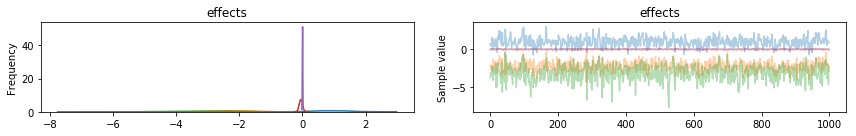

In [626]:
pm.traceplot(trace)

In [627]:
new_y = test['diag']


In [628]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [629]:
new_patientid = test['patientid']


In [630]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [631]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of bacterial by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
eta[:20]

array([-2.35839697,  1.02216178, -3.33440598,  0.67592732, -2.25426308,
       -2.16471651, -1.95644873,  1.05085377, -3.39227261,  1.13310669,
       -2.50664527, -2.11462618, -3.33357088, -2.09059236,  0.98701124,
        0.91240445,  0.97672962, -3.23242495, -2.54263092,  1.18367966])

In [633]:
p = invlogit(eta) #probability of malaria infection

p[:20]

array([0.08640065, 0.73539347, 0.03440954, 0.66282911, 0.09498237,
       0.10296401, 0.12385189, 0.74093881, 0.03253784, 0.75641177,
       0.07539363, 0.10768334, 0.0344373 , 0.11001456, 0.72849718,
       0.71349194, 0.72645882, 0.03796358, 0.07292311, 0.76560877])

In [634]:
prediction3 = pd.DataFrame({'p_mal':p}) #build df to visualize results
prediction3['pred_mal'] = (prediction3['p_mal'] > .5) * 1

In [635]:
prediction3["diag"] = new_y.reset_index(drop=True)
prediction3["CMalaria"] = new_x.reset_index(drop=True)["CMalaria"]
prediction3["Enceph"] = new_x.reset_index(drop=True)["Enceph"]
prediction3["Mening"] = new_x.reset_index(drop=True)["Mening"]
prediction3["glasgtot"] = new_x.reset_index(drop=True)["glasgtot"]
prediction3["sbp"] = new_x.reset_index(drop=True)["sbp"]
prediction3["patientid"] = new_patientid.reset_index(drop=True)
prediction3.head(5) #observe pred_diag compared to diag to see difference between prediction and actual diagnosis

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid
0,0.086401,0,1.0,0.0,0.0,1.0,13.0,98.0,453.0
1,0.735393,1,0.0,1.0,0.0,0.0,7.0,83.0,260.0
2,0.034410,0,5.0,0.0,1.0,0.0,12.0,90.0,290.0
3,0.662829,1,0.0,1.0,0.0,0.0,15.0,91.0,196.0
4,0.094982,0,1.0,0.0,0.0,1.0,10.0,90.0,109.0


In [636]:
#Now do bact

In [637]:
y = train['diag'].copy()
y[y==2] = 0
y[y==3] = 0
y[y==4] = 0
y[y==5] = 0

In [638]:
x = train[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [639]:
patientid = train['patientid']
patientid = patientid[y.index]

In [640]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [641]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [642]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:14<00:00, 203.40it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [643]:
new_y = test['diag']

In [644]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [645]:
new_patientid = test['patientid']

In [646]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [647]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of viral by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
eta[:20]

array([-0.88467791, -3.20969148, -2.7261048 , -4.16893209, -0.46692392,
       -0.45148862,  0.38401937, -3.4921051 , -3.24832857, -3.67782915,
       -0.98519503, -1.21747521, -3.16324675, -0.40123006, -3.56557917,
       -4.70288873, -3.54236366, -2.5211179 , -0.90394076, -3.35676473])

In [648]:
p = invlogit(eta) #probability of viral infection

p[:20]

array([0.29220934, 0.03880264, 0.06145043, 0.01523313, 0.38534457,
       0.38900689, 0.59484216, 0.0295377 , 0.03738699, 0.02465458,
       0.27186219, 0.22838107, 0.04057248, 0.40101684, 0.02750281,
       0.00898753, 0.0281306 , 0.07439093, 0.28824134, 0.03367434])

In [649]:
prediction3['p_bact'] = p
prediction3['pred_bact'] = (prediction3['p_bact'] > .5) * 1
prediction3.head(5)

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid,p_bact,pred_bact
0,0.086401,0,1.0,0.0,0.0,1.0,13.0,98.0,453.0,0.292209,0
1,0.735393,1,0.0,1.0,0.0,0.0,7.0,83.0,260.0,0.038803,0
2,0.034410,0,5.0,0.0,1.0,0.0,12.0,90.0,290.0,0.061450,0
3,0.662829,1,0.0,1.0,0.0,0.0,15.0,91.0,196.0,0.015233,0
4,0.094982,0,1.0,0.0,0.0,1.0,10.0,90.0,109.0,0.385345,0


In [650]:
# Now do vir

In [651]:
y = train['diag'].copy()
y[y==1] = 0
y[y==3] = 0
y[y==4] = 0
y[y==5] = 0
y[y==2] = 1

In [652]:
x = train[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [653]:
patientid = train['patientid']
patientid = patientid[y.index]

In [654]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [655]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [656]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:13<00:00, 219.42it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [657]:
new_y = test['diag']

In [658]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [659]:
new_patientid = test['patientid']

In [660]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [661]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of viral by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
eta[:20]

array([ -3.87413111, -11.19069949,  -4.37852912, -12.89829199,
        -3.23660714,  -3.01807628,  -1.74302834, -11.39624354,
        -5.0109713 , -11.38720923,  -4.30780496,  -3.63866094,
        -4.7958283 ,  -2.80123936, -11.61195117, -12.87231838,
       -11.61308046,  -3.94993706,  -4.31175747, -10.96426362])

In [662]:
p = invlogit(eta) #probability of viral infection

p[:20]

array([2.03496680e-02, 1.38017759e-05, 1.23883979e-02, 2.50231440e-06,
       3.78111343e-02, 4.66158955e-02, 1.48928687e-01, 1.12374931e-05,
       6.62030648e-03, 1.13394748e-05, 1.32842227e-02, 2.56141876e-02,
       8.19641437e-03, 5.72572402e-02, 9.05711219e-06, 2.56815981e-06,
       9.04688997e-06, 1.88921284e-02, 1.32325138e-02, 1.73090525e-05])

In [663]:
prediction3['p_vir'] = p
prediction3['pred_vir'] = (prediction3['p_vir'] > .5) * 1
prediction3.head(5)

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid,p_bact,pred_bact,p_vir,pred_vir
0,0.086401,0,1.0,0.0,0.0,1.0,13.0,98.0,453.0,0.292209,0,0.020350,0
1,0.735393,1,0.0,1.0,0.0,0.0,7.0,83.0,260.0,0.038803,0,0.000014,0
2,0.034410,0,5.0,0.0,1.0,0.0,12.0,90.0,290.0,0.061450,0,0.012388,0
3,0.662829,1,0.0,1.0,0.0,0.0,15.0,91.0,196.0,0.015233,0,0.000003,0
4,0.094982,0,1.0,0.0,0.0,1.0,10.0,90.0,109.0,0.385345,0,0.037811,0


In [441]:
#do mal&bact

In [664]:
y = train['diag'].copy()
y[y==1] = 0
y[y==2] = 0
y[y==4] = 0
y[y==5] = 0
y[y==3] = 1

In [665]:
x = train[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [666]:
patientid = train['patientid']
patientid = patientid[y.index]

In [667]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [670]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [671]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:13<00:00, 223.86it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [672]:
new_y = test['diag']

In [673]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [674]:
new_patientid = test['patientid']

In [675]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [676]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of viral by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
eta[:20]

array([-11.74490855,  -2.97329417, -11.77119884,  -3.43847578,
       -11.4998465 , -11.5688129 , -11.0786888 ,  -3.22917492,
       -12.14337498,  -3.45515554, -11.69171848, -12.23758861,
       -12.12759865, -11.59540793,  -3.23082746,  -4.08817007,
        -3.20257988, -11.6972748 , -11.59285196,  -3.23999361])

In [677]:
p = invlogit(eta) #probability of viral infection

p[:20]

array([7.92953252e-06, 4.86470403e-02, 7.72378090e-06, 3.11144009e-02,
       1.01315461e-05, 9.45636638e-06, 1.54376035e-05, 3.80824602e-02,
       5.32349610e-06, 3.06154816e-02, 8.36271984e-06, 4.84485396e-06,
       5.40814689e-06, 9.20819107e-06, 3.80219700e-02, 1.64933023e-02,
       3.90687526e-02, 8.31638313e-06, 9.23175680e-06, 3.76881222e-02])

In [678]:
prediction3['p_mal&bact'] = p
prediction3['pred_mal&bact'] = (prediction3['p_mal&bact'] > .5) * 1
prediction3.head(5)

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid,p_bact,pred_bact,p_vir,pred_vir,p_mal&bact,pred_mal&bact
0,0.086401,0,1.0,0.0,0.0,1.0,13.0,98.0,453.0,0.292209,0,0.020350,0,0.000008,0
1,0.735393,1,0.0,1.0,0.0,0.0,7.0,83.0,260.0,0.038803,0,0.000014,0,0.048647,0
2,0.034410,0,5.0,0.0,1.0,0.0,12.0,90.0,290.0,0.061450,0,0.012388,0,0.000008,0
3,0.662829,1,0.0,1.0,0.0,0.0,15.0,91.0,196.0,0.015233,0,0.000003,0,0.031114,0
4,0.094982,0,1.0,0.0,0.0,1.0,10.0,90.0,109.0,0.385345,0,0.037811,0,0.000010,0


In [679]:
#now do tbcrypto

In [680]:
y = train['diag'].copy()
y[y==1] = 0
y[y==2] = 0
y[y==3] = 0
y[y==5] = 0
y[y==4] = 1

In [681]:
x = train[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [682]:
patientid = train['patientid']
patientid = patientid[y.index]

In [683]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [690]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [691]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:14<00:00, 200.68it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [692]:
new_y = test['diag']

In [693]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [694]:
new_patientid = test['patientid']

In [695]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [696]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of viral by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
eta[:20]

array([ -4.83000788, -12.26237792, -12.26922367, -14.79680991,
        -3.86372076,  -3.57549199,  -1.64291774, -12.62363228,
       -13.26408603, -12.67443269,  -5.42551557,  -4.63702989,
       -12.95680711,  -3.27773815, -12.92773618, -14.9428611 ,
       -12.92138613, -11.64514075,  -5.40329039, -12.01859952])

In [697]:
p = invlogit(eta) #probability of viral infection

p[:20]

array([7.92318016e-03, 4.72623031e-06, 4.69398637e-06, 3.74823612e-07,
       2.05582438e-02, 2.72389115e-02, 1.62068437e-01, 3.29325021e-06,
       1.73572083e-06, 3.13013062e-06, 4.38349598e-03, 9.59349800e-03,
       2.36009315e-06, 3.63428481e-02, 2.42971010e-06, 3.23890149e-07,
       2.44518794e-06, 8.76144676e-06, 4.48156917e-03, 6.03095282e-06])

In [698]:
prediction3['p_tbcrypto'] = p
prediction3['pred_tbcrypto'] = (prediction3['p_tbcrypto'] > .5) * 1
prediction3.head(5)

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid,p_bact,pred_bact,p_vir,pred_vir,p_mal&bact,pred_mal&bact,p_tbcrypto,pred_tbcrypto
0,0.086401,0,1.0,0.0,0.0,1.0,13.0,98.0,453.0,0.292209,0,0.020350,0,0.000008,0,7.923180e-03,0
1,0.735393,1,0.0,1.0,0.0,0.0,7.0,83.0,260.0,0.038803,0,0.000014,0,0.048647,0,4.726230e-06,0
2,0.034410,0,5.0,0.0,1.0,0.0,12.0,90.0,290.0,0.061450,0,0.012388,0,0.000008,0,4.693986e-06,0
3,0.662829,1,0.0,1.0,0.0,0.0,15.0,91.0,196.0,0.015233,0,0.000003,0,0.031114,0,3.748236e-07,0
4,0.094982,0,1.0,0.0,0.0,1.0,10.0,90.0,109.0,0.385345,0,0.037811,0,0.000010,0,2.055824e-02,0


In [483]:
#Now do Other

In [699]:
y = train['diag'].copy()
y[y==1] = 0
y[y==2] = 0
y[y==3] = 0
y[y==4] = 0
y[y==5] = 1

In [700]:
x = train[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [701]:
patientid = train['patientid']
patientid = patientid[y.index]

In [702]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [703]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [704]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:14<00:00, 206.83it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [705]:
new_y = test['diag']

In [706]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [707]:
new_patientid = test['patientid']

In [708]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [709]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of viral by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
eta[:20]

array([ 0.02976037, -1.33363309,  2.10039127, -0.82382498, -0.06998311,
       -0.29829132, -0.49777829, -1.52592383,  2.03555256, -1.81851441,
        0.37665533, -0.74715517,  1.91696581, -0.4717388 , -1.38905017,
       -1.66502289, -1.35247635,  1.91807851,  0.50466371, -1.81795805])

In [710]:
p = invlogit(eta)

p[:20]

array([0.50743954, 0.20855905, 0.8909412 , 0.30495233, 0.48251136,
       0.42597524, 0.37806292, 0.17859086, 0.88447963, 0.13961223,
       0.59306616, 0.32144149, 0.8717997 , 0.38420478, 0.19955944,
       0.15908889, 0.20546581, 0.87192401, 0.62355469, 0.13967907])

In [711]:
prediction3['p_other'] = p
prediction3['pred_other'] = (prediction3['p_other'] > .5) * 1
prediction3.head(5)

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid,p_bact,pred_bact,p_vir,pred_vir,p_mal&bact,pred_mal&bact,p_tbcrypto,pred_tbcrypto,p_other,pred_other
0,0.086401,0,1.0,0.0,0.0,1.0,13.0,98.0,453.0,0.292209,0,0.020350,0,0.000008,0,7.923180e-03,0,0.507440,1
1,0.735393,1,0.0,1.0,0.0,0.0,7.0,83.0,260.0,0.038803,0,0.000014,0,0.048647,0,4.726230e-06,0,0.208559,0
2,0.034410,0,5.0,0.0,1.0,0.0,12.0,90.0,290.0,0.061450,0,0.012388,0,0.000008,0,4.693986e-06,0,0.890941,1
3,0.662829,1,0.0,1.0,0.0,0.0,15.0,91.0,196.0,0.015233,0,0.000003,0,0.031114,0,3.748236e-07,0,0.304952,0
4,0.094982,0,1.0,0.0,0.0,1.0,10.0,90.0,109.0,0.385345,0,0.037811,0,0.000010,0,2.055824e-02,0,0.482511,0


In [712]:
noref_results = prediction.append(prediction2).append(prediction3)

In [714]:
noref_results['patientid'].unique().shape == noref_results['patientid'].shape #patients are all unique

True

In [248]:
#Make final prediction of the logistic regression

In [717]:
noref_results['norefpred'] = 0
noref_results['p_max'] = noref_results['p_bact']
noref_results['p_max'][noref_results['p_vir'] > noref_results['p_max']] = noref_results['p_vir']
noref_results['p_max'][noref_results['p_mal&bact'] > noref_results['p_max']] = noref_results['p_mal&bact']
noref_results['p_max'][noref_results['p_tbcrypto'] > noref_results['p_max']] = noref_results['p_tbcrypto']
noref_results['p_max'][noref_results['p_other'] > noref_results['p_max']] = noref_results['p_other']
noref_results['p_max'][noref_results['p_mal'] > noref_results['p_max']] = noref_results['p_mal']

noref_results['norefpred'][noref_results['p_max'] == noref_results['p_bact']] = 1
noref_results['norefpred'][noref_results['p_max'] == noref_results['p_vir']] = 2
noref_results['norefpred'][noref_results['p_max'] == noref_results['p_mal&bact']] = 3
noref_results['norefpred'][noref_results['p_max'] == noref_results['p_tbcrypto']] = 4
noref_results['norefpred'][noref_results['p_max'] == noref_results['p_other']] = 5
noref_results['norefpred'][noref_results['p_max'] == noref_results['p_mal']] = 0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages

In [723]:
noref_results.head(5)

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid,p_bact,pred_bact,p_vir,pred_vir,p_mal&bact,pred_mal&bact,p_tbcrypto,pred_tbcrypto,p_other,pred_other,norefpred,p_max
0,0.699222,1,0.0,1.0,0.0,0.0,9.0,86.0,244.0,0.032664,0,0.006446,0,0.026813,0,0.000003,0,0.233583,0,0,0.699222
1,0.714583,1,0.0,1.0,0.0,0.0,7.0,94.0,100.0,0.027659,0,0.006133,0,0.031515,0,0.000005,0,0.231728,0,0,0.714583
2,0.722160,1,5.0,1.0,0.0,0.0,6.0,101.0,66.0,0.024212,0,0.005339,0,0.032952,0,0.000007,0,0.228597,0,0,0.722160
3,0.722034,1,0.0,1.0,0.0,0.0,6.0,96.0,432.0,0.026300,0,0.006453,0,0.034982,0,0.000007,0,0.232284,0,0,0.722034
4,0.707662,1,0.0,1.0,0.0,0.0,8.0,117.0,127.0,0.019222,0,0.002256,0,0.020986,0,0.000004,0,0.213214,0,0,0.707662


In [724]:
noref_results.to_csv("Outputs/noref_results.csv")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ip